<hr>
<br>
    <h1 align=center><font size = 6>Categorização de Produtos</font>
    <br>
        <font size = 5>Machine Learning - Classificação</font></h1>
<br>

Uma plataforma de infoprodutos estava com dificuldades de separar os produtos bons e os ruins de sua base de dados. De acordo com a regra de negócio da empresa, produtos com altas taxas de estorno, chargeback e alto volume de reclamações são considerados produtos ruins.

A classificação dos produtos será criada para ajudar no monitoramento dos produtos e facilitar o acompanhamento mensal com base nos seus indicadores. Assim, podendo definir metas para melhorar os produtos ativos e até utilizá-las para diferentes análises e tomadas de decisões. 

Portanto, o objetivo do projeto é categorizar de A a E, de forma hierárquica, os produtos de uma amostra com base na sua taxa de estorno, taxa de chargeback e o número de reclamações. Produtos da classe A apresentam os menores indicadores e a classe E os maiores indicadores.

### **Tópicos do Projeto**

1. **Preparação do Ambiente**\
    1.1 Importação das bibliotecas\
    1.2 Leitura dos dados\
    1.3 Identificação de valores faltantes

2. **Análise Descritiva e Diagnóstica**\
    2.1 Análise Descritiva\
    2.2 Análise Diagnóstica

3. **Seleção de Variáveis Usando Testes Estatísticos**\
    3.1 Avaliação da Normalidade dos Dados\
    3.2 Seleção de Variáveis Quantitativas (ANOVA)

4. **Preparação dos Dados**\
    4.1 Balanceamento\
    4.2 Normalização

5. **Modelagem**\
    5.1 Divisão de Treino e Teste\
    5.2 Treinamento e Avaliação

6. **Exportando o Modelo**



## 1. Preparação do Ambiente

### 1.1 Importação de bibliotecas:

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

# Balanceamento
from imblearn.over_sampling import SMOTE # pip install imbalanced-learn

# Nomalizacao
from sklearn.preprocessing import MinMaxScaler

# Divisao de treino e teste
from sklearn.model_selection import train_test_split

# algoritmo knn
from sklearn.neighbors import KNeighborsClassifier

# algoritmo arvore de decisao
from sklearn.tree import DecisionTreeClassifier

# Random Forest
from sklearn.ensemble import RandomForestClassifier

# avaliacao do modelo
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# moda , teste de normalidade
from scipy import stats

# Exportar o modelo
import joblib


### 1.2 Leitura dos Dados

In [54]:
indicadores_produtos = pd.read_csv("indicadores_produtos.csv", sep=';')
indicadores_produtos.head()

,produto_id,classificacao,tx_estorno,reclamacoes,tx_chargeback
0,123,A,0.0001,0,0.0002
1,63,A,0.0008,5,0.0005
2,130,A,0.0016,4,0.0007
3,111,A,0.0017,6,0.0009
4,117,A,0.0026,8,0.0005


### 1.3 Identificação de Valores Faltantes

In [55]:
faltantes = pd.DataFrame({'colunas':indicadores_produtos.columns, 
                      'tipo':indicadores_produtos.dtypes,
                      'Qtde valores NaN':indicadores_produtos.isna().sum(),
                      '% valores NaN':indicadores_produtos.isna().sum()/indicadores_produtos.shape[0],
                      'valores únicos por feature':indicadores_produtos.nunique()})
faltantes = faltantes.reset_index()
faltantes

,index,colunas,tipo,Qtde valores NaN,% valores NaN,valores únicos por feature
0,produto_id,produto_id,int64,0,0.0,130
1,classificacao,classificacao,object,0,0.0,5
2,tx_estorno,tx_estorno,float64,0,0.0,118
3,reclamacoes,reclamacoes,int64,0,0.0,54
4,tx_chargeback,tx_chargeback,float64,0,0.0,93


De acordo com a tabela podemos ver que não existem valores faltantes em nenhuma das variáveis. Inclusive, todas as variáveis apresentam o formato correto.

    1. Qualitativas: classificacao
    2. Quantitativo: produto_id, tx_estorno, reclamacoes, tx_chargeback

## 2. Análise Descritiva e Diagnóstica

### 2.1 Análise descritiva

In [56]:
indicadores_produtos.iloc[:,1:].describe()

,tx_estorno,reclamacoes,tx_chargeback
count,130.000000,130.000000,130.000000
mean,0.039272,32.892308,0.011055
std,0.021693,15.878046,0.008577
min,0.000100,0.000000,0.000100
25%,0.021875,21.250000,0.003150
50%,0.037200,32.000000,0.008500
75%,0.058925,44.750000,0.017000
max,0.079600,75.000000,0.029700


**Insights** 

A amostra apresenta um total de 130 produtos.

Taxa de Estorno
- A média da taxa de estorno é de 3,93%
- 50% dos produtos apresentam taxa de estorno abaixo de 3,72%

Reclamações
- A média de reclamações é de 33
- 50% dos produtos apresentam o número de reclamações abaixo de 32%

Taxa de Chargeback
- A média da Taxa de Chargeback é de 1,11%
- 50% dos produtos apresentam taxa de chargeback abaixo de 0,85%

#### Distribuição e Frequência

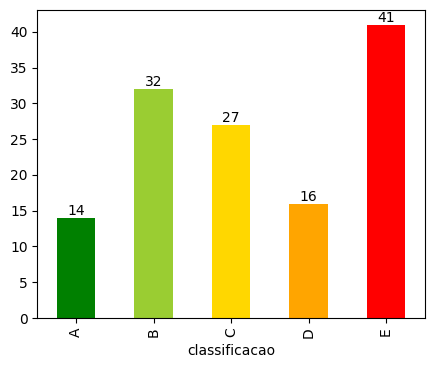

% classificacao
E    31.54
B    24.62
C    20.77
D    12.31
A    10.77
Name: count, dtype: float64


In [57]:
cores = ['green','yellowgreen','gold', 'orange', 'red']

ordem_classificacao = ['A', 'B', 'C', 'D', 'E'] 
contagem_classificacoes = indicadores_produtos['classificacao'].value_counts().reindex(ordem_classificacao)

plt.figure(figsize=(5, 4))
barras = contagem_classificacoes.plot.bar(color=cores)

for barra in barras.patches:
    y = barra.get_height()
    x = barra.get_x() + barra.get_width() / 2
    plt.text(x, y, f'{y}', ha='center', va='bottom')

plt.show()

# Percent de cada categoria
print('%', round(indicadores_produtos['classificacao'].value_counts()/len(indicadores_produtos)*100, 2))

Nota-se que a maior parcela de produtos (31.5%) está na classificação E e a menor (10.8%) na classe A. Isso mostra que a amostra selecionada tem uma baixa qualidade dos produtos, já que, teoricamente, a classe A representa os produtos bons e E representa os produtos ruins.

In [58]:
def hitogram_skew(df, variable):
    plt.figure(figsize=(10, 7))
    plt.subplot(2, 1, 1)
    df[variable].hist(bins=50, label=variable, alpha=0.8, color = 'grey')
    plt.axvline(np.mean(df[variable]), ls='--', c='b', label="Média")
    plt.axvline(np.median(df[variable]), ls=':', c='g', label="Mediana")
    mode = stats.mode(df[variable])
    plt.axvline(mode[0], ls=':', c='r', label="Moda")
    plt.title("Distribuição de Frequência")
    plt.legend()

    plt.subplot(2, 1, 2)
    df[variable].hist(bins=50, label=variable, alpha=0.8, color = 'grey',cumulative=True)
    plt.title("Frequência Acumulada")
    plt.legend()    

    print('Assimetria (Skewness):', df[variable].skew())


Assimetria (Skewness): 0.06742913252220169


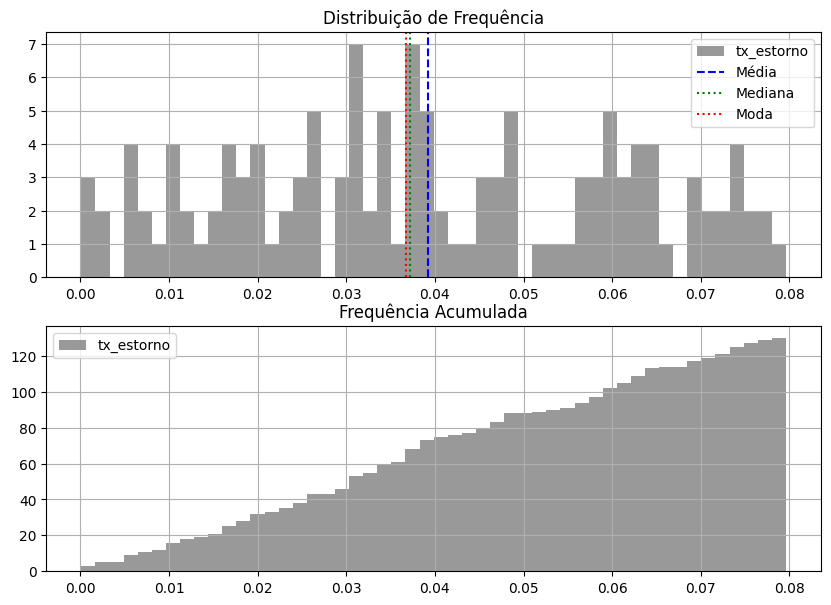

In [59]:
hitogram_skew(indicadores_produtos, 'tx_estorno')

Como o valor Skew está bem próximo de 0 isso mostra que a distribuição é aproximadamente simétrica, mas não perfeitamente simétrica. Isso mostra que a distribuição está próxima da normal. As observações estão bem distribuídas em torno da média.

`-0.5 < Skew < 0.5`

Assimetria (Skewness): 0.32151777991099173


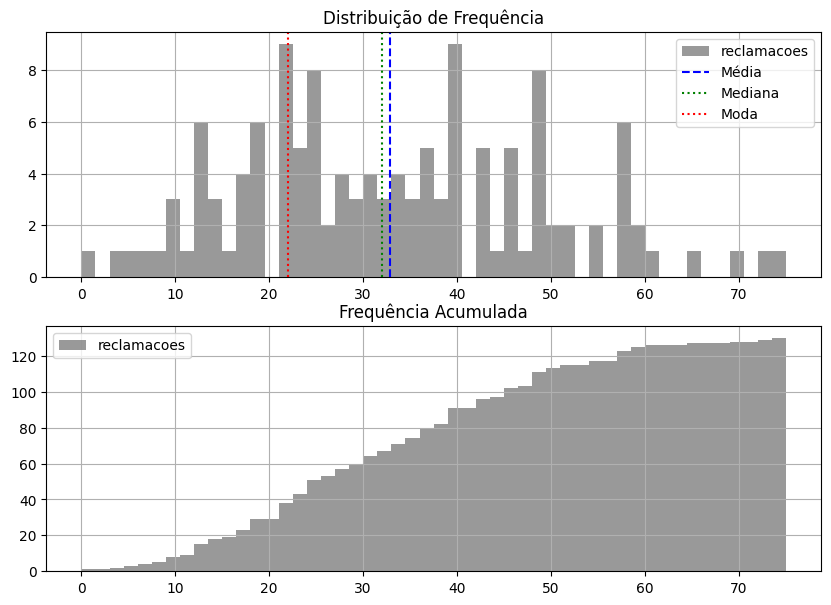

In [60]:
hitogram_skew(indicadores_produtos, 'reclamacoes')

De acordo com a análise gráfico e o resultado do valor de Skew, a distribuição é aproximadamente simétrica. Além disso, grande parte dos produtos apresentam em 22 a 40 reclamações.

`-0.5 < Skew < 0.5`

Assimetria (Skewness): 0.5801344743913182


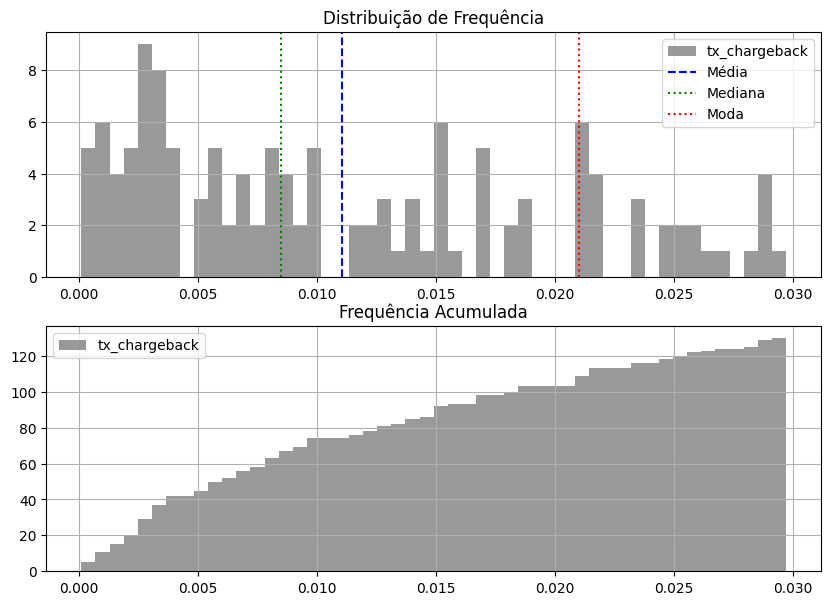

In [61]:
hitogram_skew(indicadores_produtos, 'tx_chargeback')

De acordo com a análise gráfico e o resultado do valor de Skew, a distribuição apresenta uma assimetria moderada. Além disso, grande parte dos produtos apresentam taxa de chargeback abaixo de 1%.

`0.5 < Skew < 1`

#### Boxplot

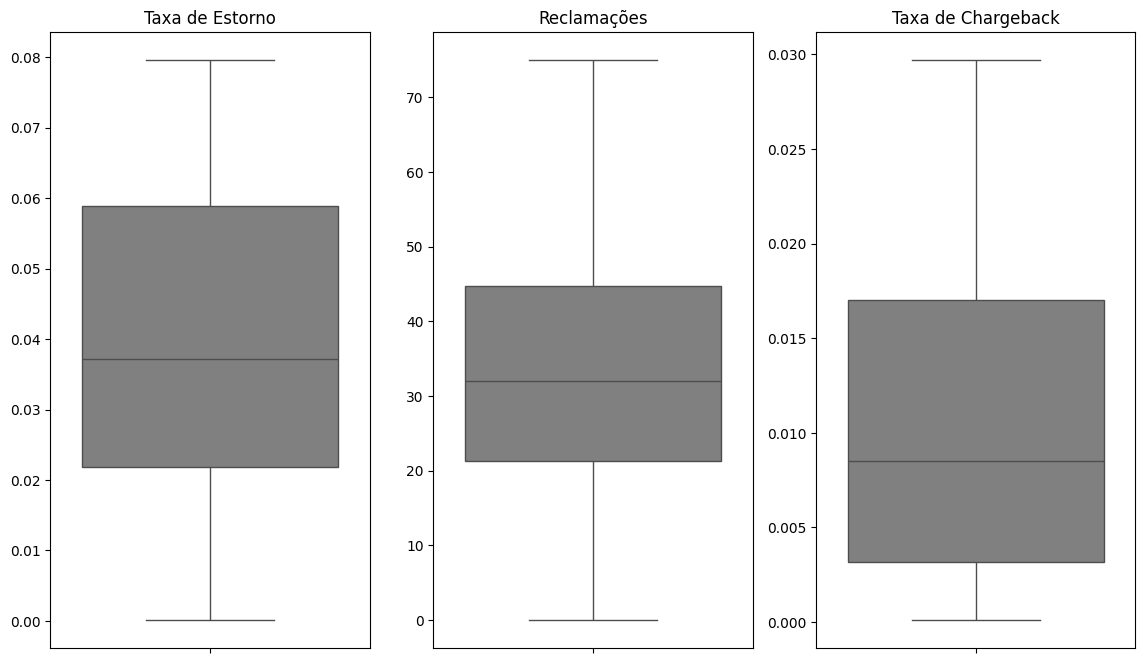

In [62]:
plt.figure(figsize=(14, 8))
variaveis = ["tx_estorno", "reclamacoes", "tx_chargeback"]
titulos = ["Taxa de Estorno", "Reclamações", "Taxa de Chargeback"]

for i in range(3):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(indicadores_produtos[variaveis[i]], color='grey')
    plt.ylabel("")  # Remove o rótulo do eixo y
    plt.title(titulos[i])

plt.show()

De acordo com os boxplots nenhuma variável apresenta valores muito distantes da média, portanto não será necessário a remoção de outliers.

#### Correlação

Para verificar a correlação das variáveis independentes com a classificação dos produtos, foi necessário passar a variável categórica 'classificacao' para uma variável númerica indicando uma hierarquia.

`A = 5`\
`B = 4`\
`C = 3`\
`D = 2`\
`E = 1`

In [63]:
indicadores_produtos['classificacao_id'] = indicadores_produtos['classificacao'].map( {'A':5, 'B':4, 'C':3, 'D':2, 'E':1} )

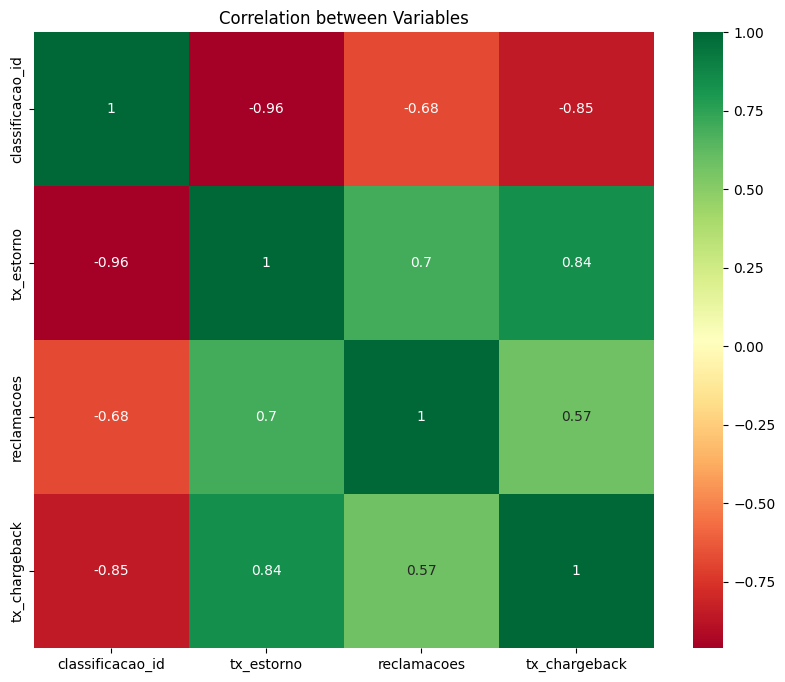

In [64]:
variaveis = indicadores_produtos[["classificacao_id","tx_estorno", "reclamacoes", "tx_chargeback"]]

plt.figure(figsize=(10, 8))
sns.heatmap(variaveis.corr(), cmap='RdYlGn', annot = True)
plt.title("Correlation between Variables")
plt.show()

De acordo com o heatmap, vemos que todas as variáveis apresentam uma relação negativa com a classificação dos produtos. As taxas de estorno e chargeback apresentaram uma correlação negativa de 0.97 e 0.87, respectivamente. Como foi falado anteriormente, as reclamações apresentaram a menor correlação entre a variável de classificação.

Além disso, todas as variáveis independentes apresentaram relação positivas entre si, ou seja, produtos com alto nível de chargeback também apresentam alto estorno e reclamações.

<h4> 2.2 Análise Diagnóstica</h4><a id="22"></a>

#### Qual o relacionamento das variáveis com cada classe? É possível observar a existência de hierarquia entre as classes?

In [65]:
indicadores_produtos.iloc[:,1:].groupby(['classificacao']).mean()

,tx_estorno,reclamacoes,tx_chargeback,classificacao_id
classificacao,,,,
A,0.005836,10.642857,0.001714,5.0
B,0.020434,25.218750,0.003881,4.0
C,0.034800,31.259259,0.007341,3.0
D,0.047169,39.375000,0.015994,2.0
E,0.065256,45.024390,0.020361,1.0


Analisando o quadro das médias das variáveis por classe, vemos que quanto maior os valores, mais baixa é a classificação. Isso mostra que as classes pré definidas estão de acordo com o esperado.

In [66]:
indicadores_produtos.groupby(['classificacao'])['reclamacoes'].sum()

classificacao
A     149
B     807
C     844
D     630
E    1846
Name: reclamacoes, dtype: int64

Vemos que a classe com maior número de reclamações é a E (43.2%) e a menor é a classe A (3.5%). Porém, a classe D apresenta menos reclamações que as classes B e C. Podendo interpretar, de forma superficial, que a variável de reclamações deve apresentar um menor peso sobre a mudança de classificação.

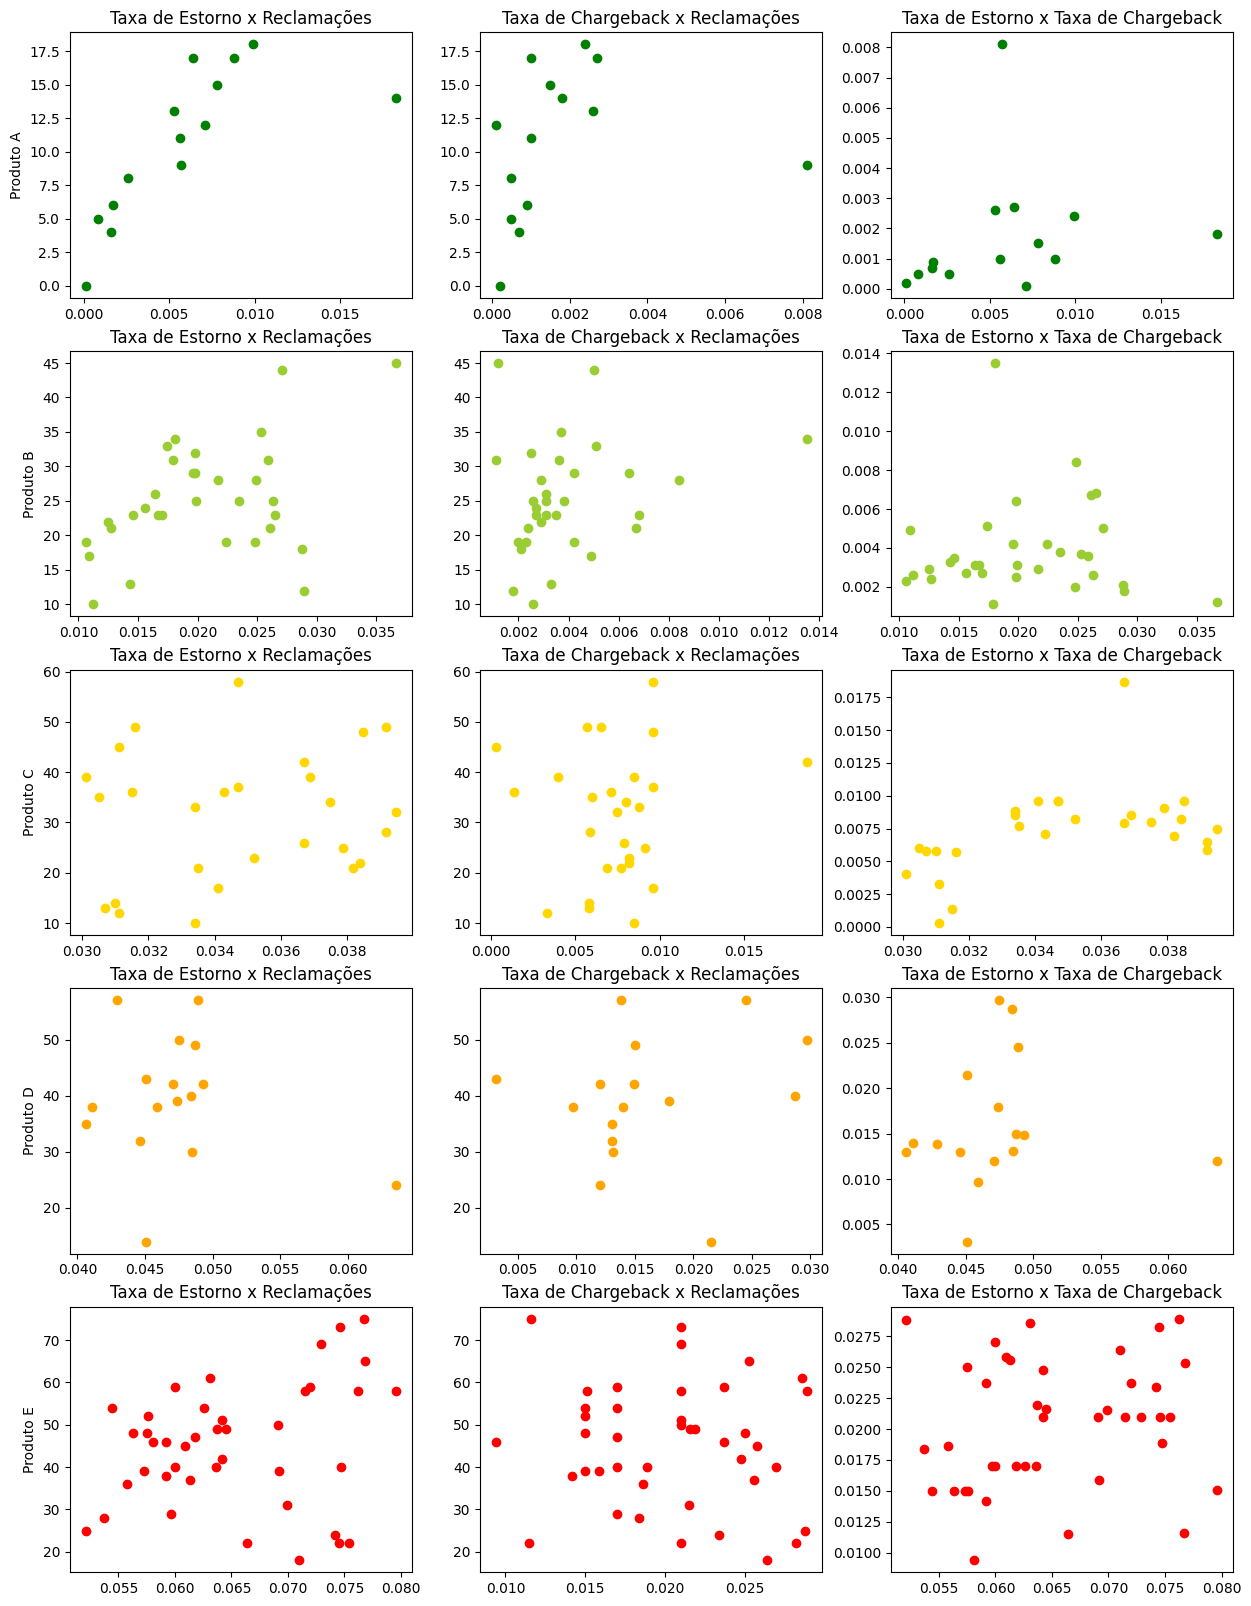

In [67]:
# Correlação entre as variáveis independentes por Classificação
produto_A = indicadores_produtos.query('classificacao == "A"')
produto_B = indicadores_produtos.query('classificacao == "B"')
produto_C = indicadores_produtos.query('classificacao == "C"')
produto_D = indicadores_produtos.query('classificacao == "D"')
produto_E = indicadores_produtos.query('classificacao == "E"')

produtos = [produto_A, produto_B, produto_C, produto_D, produto_E]
nomes_produtos = ["Produto A", "Produto B", "Produto C", "Produto D", "Produto E"]

titulos = [
    "Taxa de Estorno x Reclamações",
    "Taxa de Chargeback x Reclamações",
    "Taxa de Estorno x Taxa de Chargeback"
]

plt.figure(figsize=(15, 20))

contador = 1

for produto, nome, cor in zip(produtos, nomes_produtos, cores):
    for i, titulo in enumerate(titulos):
        plt.subplot(5, 3, contador)
        if titulo == "Taxa de Estorno x Reclamações":
            plt.scatter(produto['tx_estorno'], produto['reclamacoes'], color=cor)
        elif titulo == "Taxa de Chargeback x Reclamações":
            plt.scatter(produto['tx_chargeback'], produto['reclamacoes'], color=cor)
        elif titulo == "Taxa de Estorno x Taxa de Chargeback":
            plt.scatter(produto['tx_estorno'], produto['tx_chargeback'], color=cor)

        plt.title(titulo)

        if i == 0:
            plt.ylabel(nome)

        contador += 1

plt.show()

O gráfico de dispersão apresenta a relação das variáveis independentes dentro de cada grupo de classe. Análisando de forma separada, não é possível encontrar um padrão entre os dados. Apenas no produto A é possível ver uma relação positiva entre as variáveis.

/var/folders/wt/_hm9npcx6xnbt_qw03pfvm940000gn/T/ipykernel_33072/233744250.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="classificacao", y=variaveis[i], data=indicadores_produtos, palette=cores_por_classificacao)
/var/folders/wt/_hm9npcx6xnbt_qw03pfvm940000gn/T/ipykernel_33072/233744250.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="classificacao", y=variaveis[i], data=indicadores_produtos, palette=cores_por_classificacao)
/var/folders/wt/_hm9npcx6xnbt_qw03pfvm940000gn/T/ipykernel_33072/233744250.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same

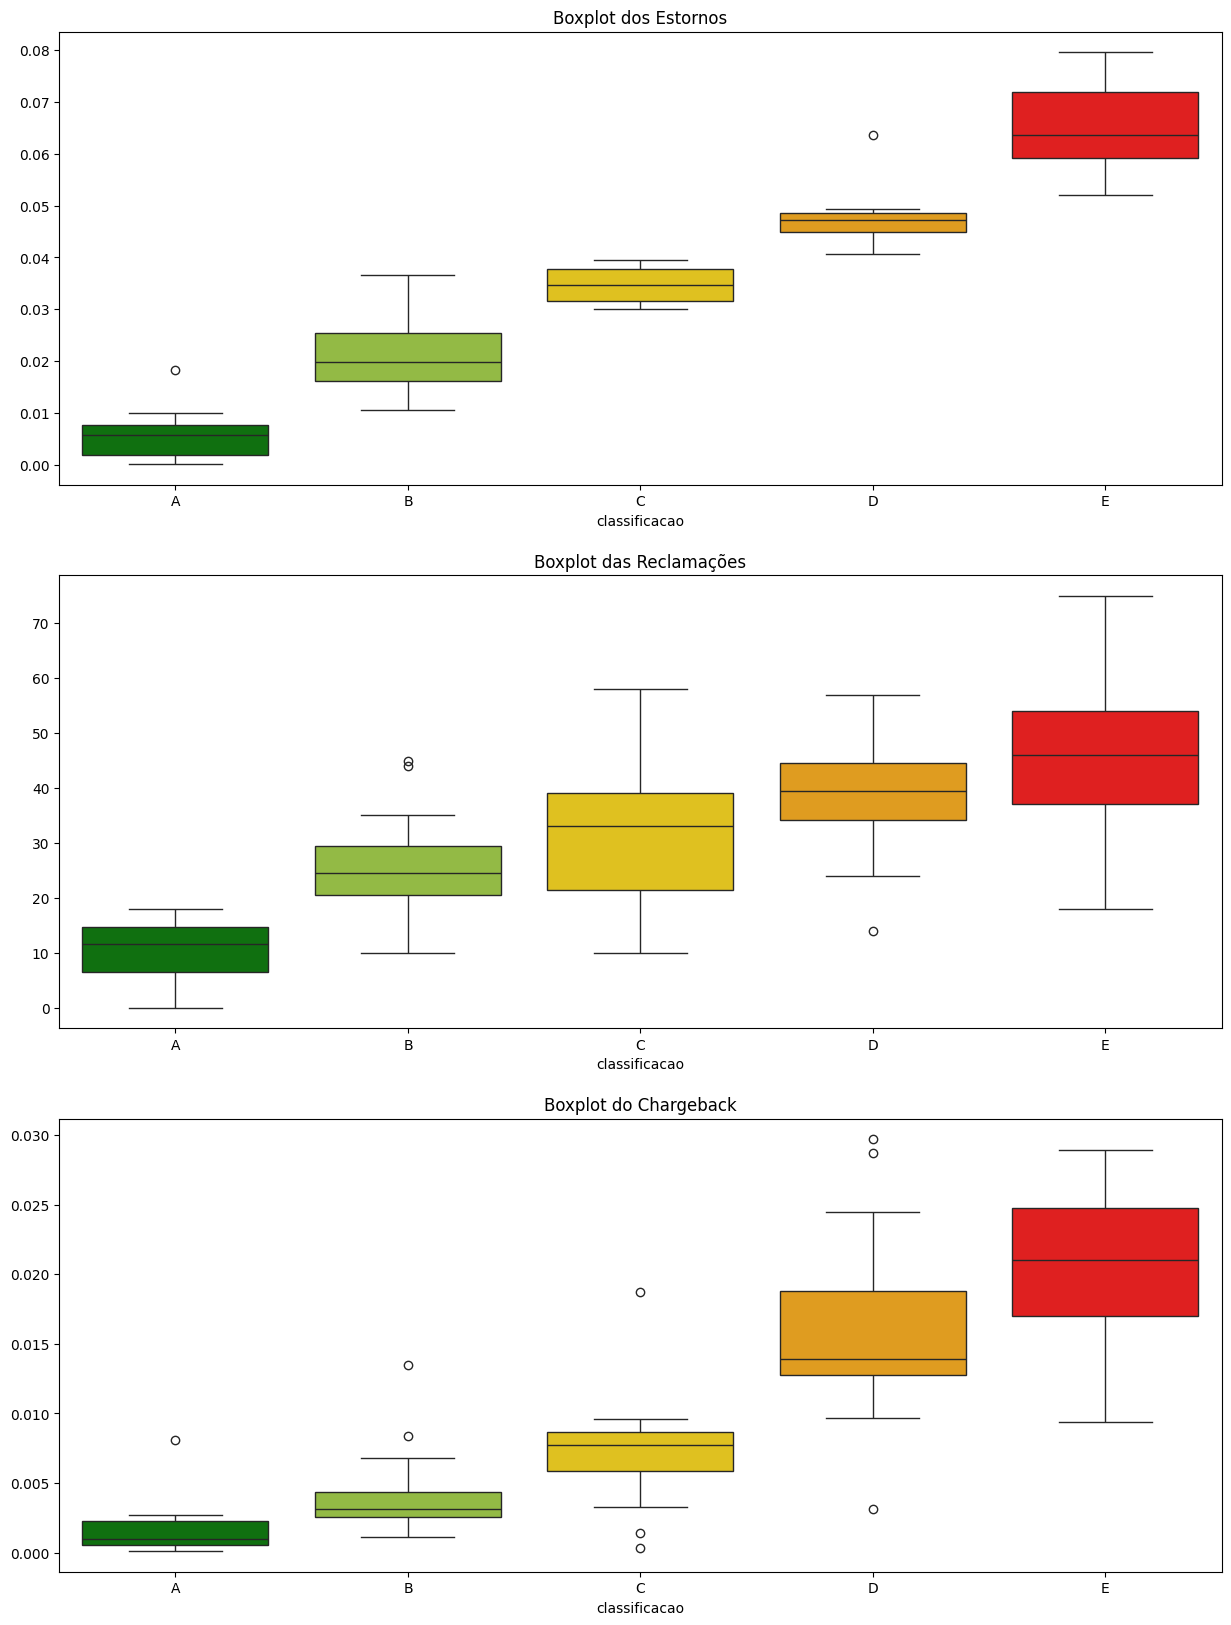

In [68]:
plt.figure(figsize=(15, 20))
variaveis = ["tx_estorno", "reclamacoes", "tx_chargeback"]
titulos = ["Boxplot dos Estornos", "Boxplot das Reclamações", "Boxplot do Chargeback"]

cores_por_classificacao = {"A": "green", "B": "yellowgreen", "C": "gold", "D": "orange", "E": "red"}

for i in range(3):
    plt.subplot(3, 1, i + 1)
    sns.boxplot(x="classificacao", y=variaveis[i], data=indicadores_produtos, palette=cores_por_classificacao)
    plt.ylabel("")  # Remove o rótulo do eixo y
    plt.title(titulos[i])

plt.show()

De acordo com o boxplot, vemos que os maiores valores são do grupo E e os menores valores do grupo A. Além disso, a ordem crescente dos gráficos também mostra que existe uma hierarquia entre as classes. Sendo a classe A superior a classe E, como anunciado anteriormente.

## 3. Seleção de Variáveis Usando Testes Estatísticos

### 3.1 Avaliação da Normalidade dos Dados

In [69]:
def normality_validation(data,variavel):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(data[variavel])
    plt.subplot(1,2,2)
    stats.probplot(data[variavel], dist="norm", plot=plt)
    plt.show()

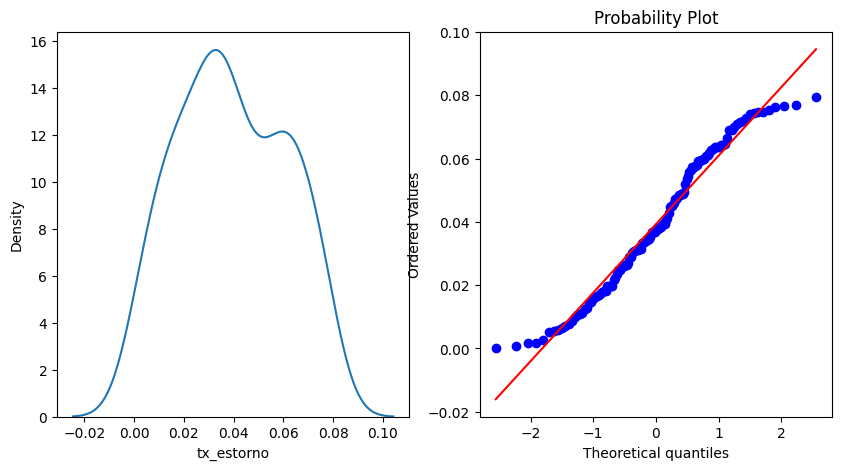

In [70]:
normality_validation(indicadores_produtos, 'tx_estorno')

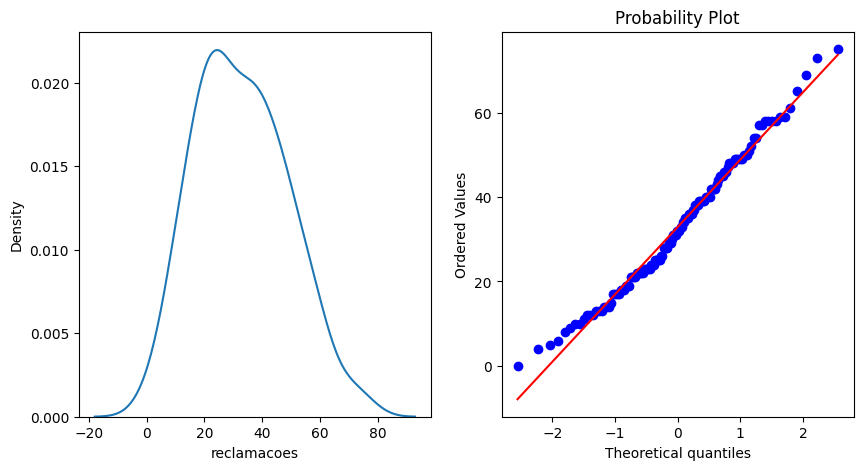

In [71]:
normality_validation(indicadores_produtos, 'reclamacoes')

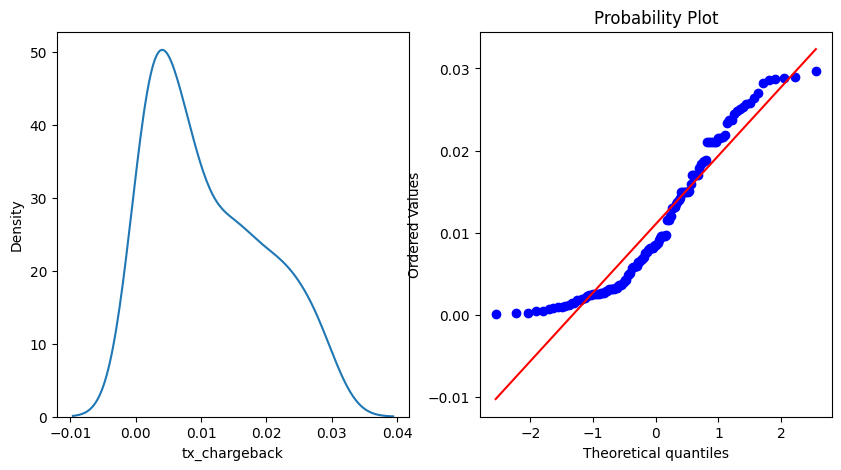

In [72]:
normality_validation(indicadores_produtos, 'tx_chargeback')

De acordo com a análise gráfica, apenas a variável `tx_chargeback` apresente a não normalidade dos dados. Sendo assim, necessário realizar a normalização.

### 3.2 Seleção de Variáveis Quantitativas (ANOVA)

Para testar a significância da variável do modelo, foi necessário aplicar o teste da ANOVA One-Way. A ANOVA é um teste paramétrico, ou seja, as variáveis testadas precisam apresentar uma distribuição do tipo normal.

As variáveis `tx_estorno` e `reclamacoes` foram consideradas como dist. normal, de acordo com as análises anteriores. No caso da `tx_chargeback`, foi necessário normalizar aplicando `log` para realizar o teste paramétrico.

Hipóteses do teste ANOVA:

H0: Todas as médias da população são iguais\
H1: Pelo menos uma das médias da população se difere das demais

In [73]:
def test_anova(variavel):
    class_a = indicadores_produtos.loc[indicadores_produtos['classificacao'] == 'A'][variavel]
    class_b = indicadores_produtos.loc[indicadores_produtos['classificacao'] == 'B'][variavel]
    class_c = indicadores_produtos.loc[indicadores_produtos['classificacao'] == 'C'][variavel]
    class_d = indicadores_produtos.loc[indicadores_produtos['classificacao'] == 'D'][variavel]
    class_e = indicadores_produtos.loc[indicadores_produtos['classificacao'] == 'E'][variavel]
    
    f, p = stats.f_oneway(class_a, class_b, class_c, class_d, class_e)

    print(f"F value: {round(f,4)} | P-value: {p,4}")
    if p <=  0.05:
        print('Rejeita a hipótese nula. Portanto, pelo menos uma das médias da população se difere das demais')
    else:
        print('Não rejeita a hipótese nula. Portanto, Todas as médias da população são iguais')

In [74]:
test_anova('tx_estorno')

F value: 392.4695 | P-value: (1.0133681107901944e-69, 4)
Rejeita a hipótese nula. Portanto, pelo menos uma das médias da população se difere das demais


In [75]:
test_anova('reclamacoes')

F value: 28.7862 | P-value: (5.864393555469051e-17, 4)
Rejeita a hipótese nula. Portanto, pelo menos uma das médias da população se difere das demais


Agora transformar as variáveis que não apresentaram distribuição normal em normal e aplicar o teste ANOVA One-Way:

In [76]:
indicadores_produtos['tx_chargeback_log']=np.log(indicadores_produtos['tx_chargeback'])

In [77]:
test_anova('tx_chargeback_log')

F value: 81.0922 | P-value: (8.571164009503813e-34, 4)
Rejeita a hipótese nula. Portanto, pelo menos uma das médias da população se difere das demais


De acordo com os testes, todas as variáveis apresentam diferença entre as médias das classificações, portanto, todas serão significativas para o modelo. Além disso, de acordo com a análise de correlação apresentada anteriormente todas as variáveis apresentam alta correlação com a variável de classes.

## 4. Preparação dos Dados

### 4.1 Balanceamento

A base foi balanceada usando o método Oversampling por conta do baixo número de observações da amostra. Se o seu conjunto de dados é pequeno, o undersampling pode levar à perda de informações valiosas. Nesses casos, o oversampling é preferível para aumentar o tamanho da classe minoritária.

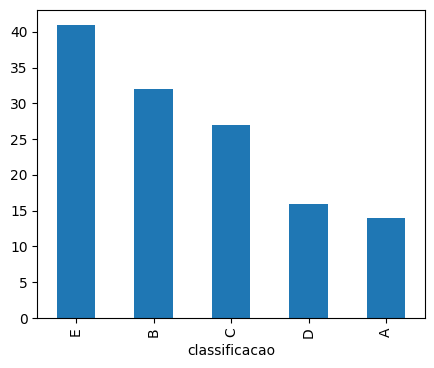

In [78]:
plt.figure(figsize=(5, 4))
indicadores_produtos['classificacao'].value_counts().plot.bar()
plt.show()

In [79]:
X = indicadores_produtos[['tx_estorno', 'reclamacoes', 'tx_chargeback']]
y = indicadores_produtos['classificacao']

In [80]:
smt = SMOTE() 
X_smote, y_smote = smt.fit_resample(X, y)

In [81]:
X_smote.head()

,tx_estorno,reclamacoes,tx_chargeback
0,0.0001,0,0.0002
1,0.0008,5,0.0005
2,0.0016,4,0.0007
3,0.0017,6,0.0009
4,0.0026,8,0.0005


classificacao
A    41
B    41
C    41
D    41
E    41
Name: count, dtype: int64
205


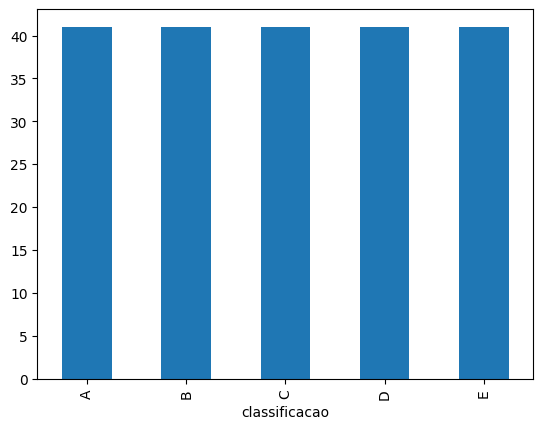

In [82]:
y_smote.value_counts().plot.bar()
print(y_smote.value_counts())
print(len(y_smote))

### 4.2 Normalização

Como uma das variáveis apresenta a não normalidade dos dados, será preferível realizar a normalização ao invés da padronização.

Além disso, alguns algoritmos de classificação, como K-Nearest Neighbors (KNN), são sensíveis à escala das variáveis de entrada. Se uma variável é medida em uma escala muito maior do que outra, ela pode dominar a função de decisão do modelo, levando a resultados imprecisos.

In [83]:
norm = MinMaxScaler()

X_normalizado = pd.DataFrame(norm.fit_transform(X_smote), columns=['tx_estorno', 'reclamacoes', 'tx_chargeback'])

X_normalizado

,tx_estorno,reclamacoes,tx_chargeback
0,0.000000,0.000000,0.003378
1,0.008805,0.066667,0.013514
2,0.018868,0.053333,0.020270
3,0.020126,0.080000,0.027027
4,0.031447,0.106667,0.013514
...,...,...,...
200,0.600183,0.520000,0.579237
201,0.566834,0.560000,0.115118
202,0.566780,0.560000,0.114173
203,0.639151,0.386667,0.424587


## 5. Modelagem

 ### 5.1 Divisão de Treino e Teste

In [84]:
X = X_normalizado.copy()

In [85]:
X.head()

,tx_estorno,reclamacoes,tx_chargeback
0,0.000000,0.000000,0.003378
1,0.008805,0.066667,0.013514
2,0.018868,0.053333,0.020270
3,0.020126,0.080000,0.027027
4,0.031447,0.106667,0.013514


In [86]:
X.shape

(205, 3)

In [87]:
X.dtypes

tx_estorno       float64
reclamacoes      float64
tx_chargeback    float64
dtype: object

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y_smote, test_size=0.3)

print ('Set de Treino:', X_train.shape,  y_train.shape)
print ('Set de Teste:', X_test.shape,  y_test.shape)

Set de Treino: (143, 3) (143,)
Set de Teste: (62, 3) (62,)


Foi utilizado a regra 70/30, a amostra foi dividida em base de treino com 70% dos dados e a base de teste com 30%. Pelo tamanho moderado da amostra, usar a regra 70/30 já é o suficiente para treinar o modelo de forma eficiente.

In [89]:
X_train.head()

,tx_estorno,reclamacoes,tx_chargeback
100,0.749686,0.386667,0.570946
107,0.792453,0.813333,0.962838
194,0.532689,0.480000,0.480818
23,0.208805,0.306667,0.101351
191,0.595937,0.653333,0.991384


**Contagem de classes por traino e teste**

In [90]:
df_train = pd.DataFrame({'y_train':y_train.value_counts(), 'y_test':y_test.value_counts()})
df_train

,y_train,y_test
classificacao,,
A,33,8
B,27,14
C,26,15
D,29,12
E,28,13


### 5.2 Treinamento e Avaliação

Para esse problema, escolhi comparar o desempenho de 3 métodos de classificação distintos. São eles: 

`1. KNN (K-Nearest Neighbors)` \
`2. Árvore de Decisão` \
`3. Random Forest`

Esse projeto tem como objetivo fazer uma classificação dos produtos da amostra variando de A a E. Como o modelo é de Multi-Class usarei como métricas de avaliação:

`1. Accuracy`\
`2. Precision`\
`3. Recall`

A `macro avg` foi uma métrica relevante na análise, pois calcula o desempenho de cada classe (por exemplo, precisão, recall) e então pega a média aritmética em todas as classes. Então, a `macro avg` dá peso igual a cada classe, independentemente do número de instâncias.

##### Árvore de Decisão

In [91]:
class_tree = DecisionTreeClassifier()
class_tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [92]:
class_tree_pred = class_tree.predict(X_test)


In [93]:
print(classification_report(y_test, class_tree_pred))

              precision    recall  f1-score   support

           A       0.80      1.00      0.89         8
           B       0.92      0.86      0.89        14
           C       1.00      0.93      0.97        15
           D       0.86      1.00      0.92        12
           E       1.00      0.85      0.92        13

    accuracy                           0.92        62
   macro avg       0.92      0.93      0.92        62
weighted avg       0.93      0.92      0.92        62



#### KNN

In [94]:
knn = KNeighborsClassifier(metric='euclidean')
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean')

In [95]:
knn_pred = knn.predict(X_test)

In [96]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           A       0.73      1.00      0.84         8
           B       1.00      0.79      0.88        14
           C       0.83      1.00      0.91        15
           D       0.90      0.75      0.82        12
           E       1.00      0.92      0.96        13

    accuracy                           0.89        62
   macro avg       0.89      0.89      0.88        62
weighted avg       0.91      0.89      0.89        62



#### Random Forest

In [97]:
forest_model = RandomForestClassifier(random_state=1)
forest_model.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [98]:
forest_pred = forest_model.predict(X_test)

In [99]:
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

           A       0.80      1.00      0.89         8
           B       0.92      0.86      0.89        14
           C       1.00      0.93      0.97        15
           D       0.92      1.00      0.96        12
           E       1.00      0.92      0.96        13

    accuracy                           0.94        62
   macro avg       0.93      0.94      0.93        62
weighted avg       0.94      0.94      0.94        62



De acordo com o resultado dos modelos, o algoritmo de Árvore de Decisão trouxe um resultado superior ao algoritmo de KNN e Random Forest. Portanto, ele foi o escolhido para melhor classificar os produtos da plataforma.

### 5.3 Matriz de Confusão

<Axes: xlabel='Predicted', ylabel='Actual'>

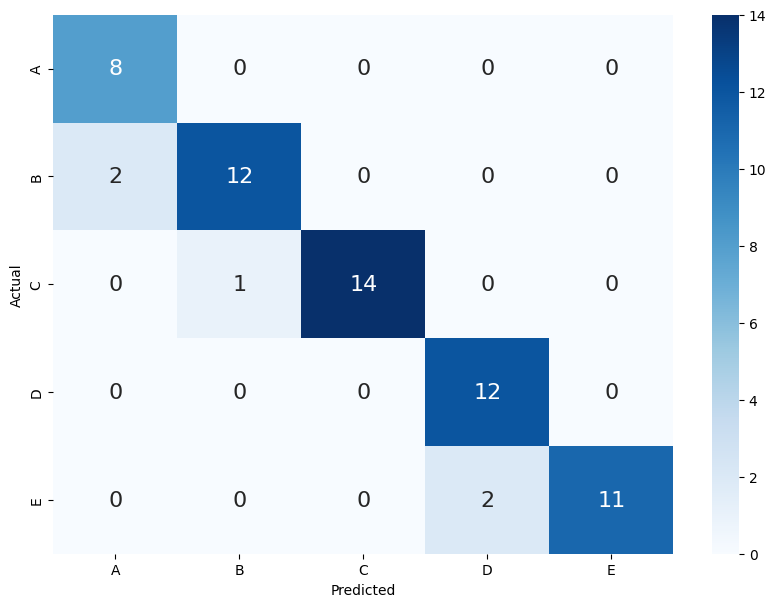

In [100]:
data = confusion_matrix(y_test, class_tree_pred)
df_matrix = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_matrix.index.name = 'Actual'
df_matrix.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(df_matrix, cmap="Blues", annot=True, annot_kws={"size": 16})

### 6. Exportando o Modelo

In [101]:
joblib.dump( class_tree, 'class_tree.pkl')

['class_tree.pkl']

In [102]:
# Testando o modelo treinado
modelo_treinado = joblib.load('class_tree.pkl')

In [103]:
# Criando DataFrame
X_test = pd.DataFrame(X_test, columns = ['tx_estorno','reclamacoes','tx_chargeback'])

# Testando
modelo_treinado.predict(X_test.head(1).values)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array(['C'], dtype=object)

<div style="text-align:right;">
Mariana Caetano Vidal
    <br>
    Março, 2024.